In [1]:
import pandas as pd
import yfinance as yf
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../Scripts"))
sys.path.append(os.path.abspath("../src"))

from Download_data import StockData
from data_preprocessing import DataPreprocessor
from eda import StockAnalysis
from model_building import ARIMAmodel, SARIMA, LSTMForecast
from grid_search import LSTM_search

## Task 1: Preprocess and Explore the Data
### Load and Clean Data

In [2]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = "2015-07-01"
end_date = "2025-07-31"

# Create instance of StockData
stock_data = StockData(tickers, start_date, end_date)


In [3]:
df = stock_data.download_data()

c:\Users\Specter\Documents\Tenx_Academy\Week-11\Time-Series-Forecasting-Portfolio-Optimization\src\Download_data.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date)
[*********************100%***********************]  3 of 3 completed


In [4]:
df.head()

Price           Close                              High              \
Ticker            BND         SPY       TSLA        BND         SPY   
Date                                                                  
2015-07-01  60.816719  174.917130  17.943333  60.914445  175.363905   
2015-07-02  60.967087  174.756927  18.667999  61.027228  175.566188   
2015-07-06  61.177593  174.259567  18.648001  61.222702  175.043527   
2015-07-07  61.237732  175.355469  17.858667  61.470773  175.481910   
2015-07-08  61.410629  172.413467  16.997334  61.463252  174.293296   

Price                        Low                              Open  \
Ticker           TSLA        BND         SPY       TSLA        BND   
Date                                                                 
2015-07-01  18.174667  60.764097  174.124732  17.856667  60.794167   
2015-07-02  18.830000  60.937016  174.335441  18.220667  60.937016   
2015-07-06  18.779333  61.057316  173.256426  18.420000  61.222702   
2015-07-07  18.346666  61.237732  172.059437  17.384666  61.410637   
2015-07-08  17.386667  61.312898  172.177436  16.954000  61.373039   

Price                               Volume                        
Ticker             SPY       TSLA      BND        SPY       TSLA  
Date                                                              
2015-07-01  175.111010  18.073999  5399300  135979900   31518000  
2015-07-02  175.397596  18.680000  1060100  104373700  107458500  
2015-07-06  173.458745  18.591999  2210700  117975400   61828500  
2015-07-07  174.461918  18.333332  4183200  173820200   91576500  
2015-07-08  174.006688  17.288000  1967800  164020100   93316500

In [5]:
# Extract different price categories into separate DataFrames.
close_df, high_df, low_df, open_df, volume_df = stock_data.extract_price_categories()

In [6]:
# Reset index of DataFrames.
close_df, high_df, low_df, open_df, volume_df = stock_data.reset_indexes()

In [7]:
close_df, high_df, low_df, open_df, volume_df = stock_data.melt_data()

In [8]:
# Get the merged DataFrame
stock_data.merge_data()
df_merged = stock_data.get_merged_data()

In [9]:
df_merged.head()

,Date,Ticker,Open,Low,Volume,High,Close
0,2015-07-01,TSLA,18.073999,17.856667,31518000,18.174667,17.943333
1,2015-07-02,TSLA,18.680000,18.220667,107458500,18.830000,18.667999
2,2015-07-06,TSLA,18.591999,18.420000,61828500,18.779333,18.648001
3,2015-07-07,TSLA,18.333332,17.384666,91576500,18.346666,17.858667
4,2015-07-08,TSLA,17.288000,16.954000,93316500,17.386667,16.997334


###  Data cleaning and Understanding

In [10]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7605 entries, 0 to 7604
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7605 non-null   datetime64[ns]
 1   Ticker  7605 non-null   object        
 2   Open    7605 non-null   float64       
 3   Low     7605 non-null   float64       
 4   Volume  7605 non-null   int64         
 5   High    7605 non-null   float64       
 6   Close   7605 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 416.0+ KB


In [11]:
# Summary statistics
df_merged.describe()

,Date,Open,Low,Volume,High,Close
count,7605,7605.000000,7605.000000,7.605000e+03,7605.000000,7605.000000
mean,2020-07-12 16:49:59.289940992,178.199177,176.439129,6.788282e+07,179.837741,178.208641
min,2015-07-01 00:00:00,9.488000,9.403333,0.000000e+00,10.331333,9.578000
25%,2018-01-04 00:00:00,64.726125,64.633092,5.890700e+06,64.791238,64.718086
50%,2020-07-14 00:00:00,94.400665,91.734001,6.240820e+07,97.666664,94.571335
75%,2023-01-19 00:00:00,264.350006,261.211439,9.666270e+07,267.309998,264.350006
max,2025-07-30 00:00:00,638.349976,635.539978,9.140820e+08,638.669983,637.099976
std,NaN,151.799506,150.457747,6.784301e+07,153.033414,151.805674


In [12]:
# Count missing values per column
df_merged.isnull().sum()

Date      0
Ticker    0
Open      0
Low       0
Volume    0
High      0
Close     0
dtype: int64

In [13]:
df_merged.dtypes

Date      datetime64[ns]
Ticker            object
Open             float64
Low              float64
Volume             int64
High             float64
Close            float64
dtype: object

In [14]:
data = df_merged[['Date','Close']][df_merged['Ticker'] == 'TSLA']

In [15]:
data.to_csv('tsla.csv', index=False)

In [16]:
data = df_merged

In [17]:
data.Ticker.value_counts()

Ticker
TSLA    2535
BND     2535
SPY     2535
Name: count, dtype: int64

In [18]:
tsla = data[(data.Ticker=='TSLA')]

### Handling Duplicates

In [19]:
# Initialize the preprocessor
preprocessor = DataPreprocessor(tsla)

In [20]:
# Apply data cleaning and transformation steps
preprocessor.handle_duplicates()

Removed 0 duplicate rows.


### Check Outlier

In [21]:
preprocessor.check_outliers()

Outlier count per column: {'Open': 0, 'Low': 0, 'Volume': 176, 'High': 0, 'Close': 0}


### Data Normalization

In [22]:
# Processed Data
processed_data = preprocessor.Normalized_data()
processed_data.head()

,Open,Low,Volume,High,Close,Date
0,0.018409,0.018865,0.023131,0.016401,0.017788,2015-07-01
1,0.019708,0.019677,0.107186,0.017772,0.019329,2015-07-02
2,0.019519,0.020122,0.056680,0.017666,0.019286,2015-07-06
3,0.018965,0.017811,0.089607,0.016761,0.017608,2015-07-07
4,0.016723,0.016850,0.091533,0.014754,0.015776,2015-07-08


### Conduct Exploratory Data Analysis (EDA):

In [23]:
# Sort index to ensure chronological order
df = processed_data

In [24]:
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df = df.set_index('Date')

# Sort by the new index
df = df.sort_index()

In [25]:
df.head()

,Open,Low,Volume,High,Close
Date,,,,,
2015-07-01,0.018409,0.018865,0.023131,0.016401,0.017788
2015-07-02,0.019708,0.019677,0.107186,0.017772,0.019329
2015-07-06,0.019519,0.020122,0.056680,0.017666,0.019286
2015-07-07,0.018965,0.017811,0.089607,0.016761,0.017608
2015-07-08,0.016723,0.016850,0.091533,0.014754,0.015776


In [26]:
# Initialize the analysis class
ts_analysis = StockAnalysis(df)

### Visualize Closing Prices

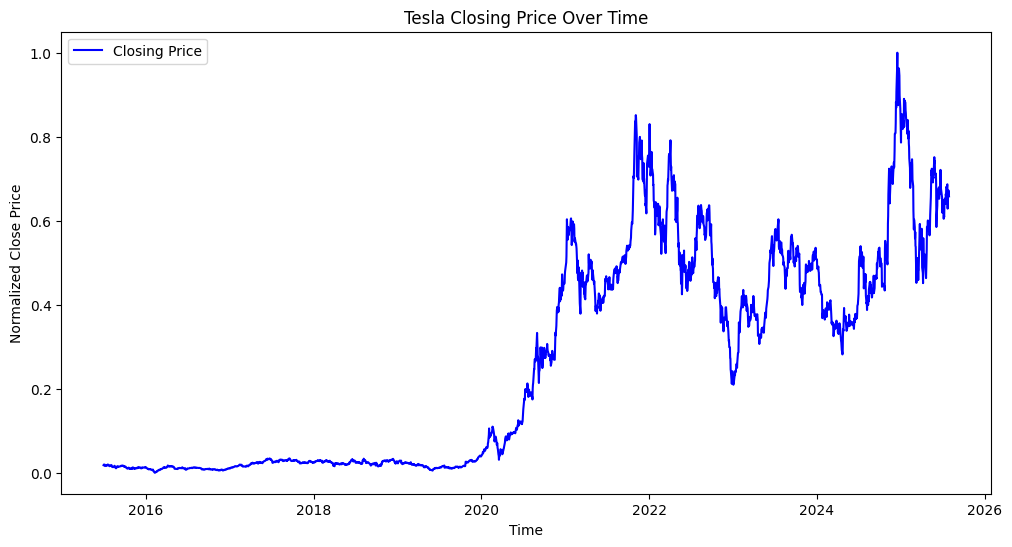

In [27]:
# Run Exploratory Data Analysis
ts_analysis.plot_closing_price()

### Calculate Daily Returns

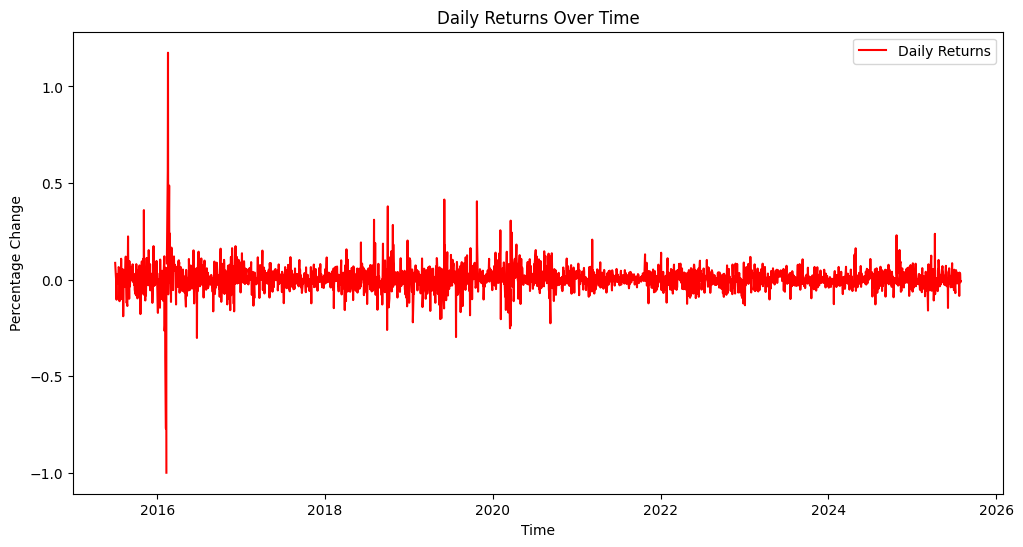

In [28]:
ts_analysis.calculate_daily_returns()

####  Performing outlier detection to identify significant anomalies

In [29]:
outliers = ts_analysis.detect_outliers()

Identified 30 outlier days with extreme returns.


In [30]:
outliers

,Date,Open,Low,Volume,High,Close,Daily Returns,Z-Score
40,2015-08-27,0.012675,0.013354,0.115356,0.012516,0.014079,0.223605,3.199757
88,2015-11-04,0.012104,0.012519,0.199539,0.010842,0.012469,0.359926,5.177664
148,2016-02-02,0.007161,0.005829,0.084103,0.005318,0.005544,-0.265816,-3.901336
149,2016-02-03,0.005899,0.004334,0.119929,0.004039,0.004226,-0.237791,-3.494721
151,2016-02-05,0.004142,0.002483,0.144936,0.002514,0.002683,-0.402085,-5.878493
152,2016-02-08,0.002113,0.000736,0.142867,0.000304,0.000612,-0.771791,-11.242627
154,2016-02-10,0.001169,0.000103,0.161022,0.000000,0.000000,-1.000000,-14.553759
157,2016-02-16,0.002341,0.001943,0.081118,0.001112,0.001630,0.560382,8.086127
158,2016-02-17,0.002384,0.002325,0.084960,0.002003,0.003545,1.174780,17.000535
161,2016-02-22,0.003974,0.004285,0.072257,0.003337,0.004830,0.487123,7.023196


### Decompose Tesla’s Stock Price (Trend, Seasonality, Residuals)

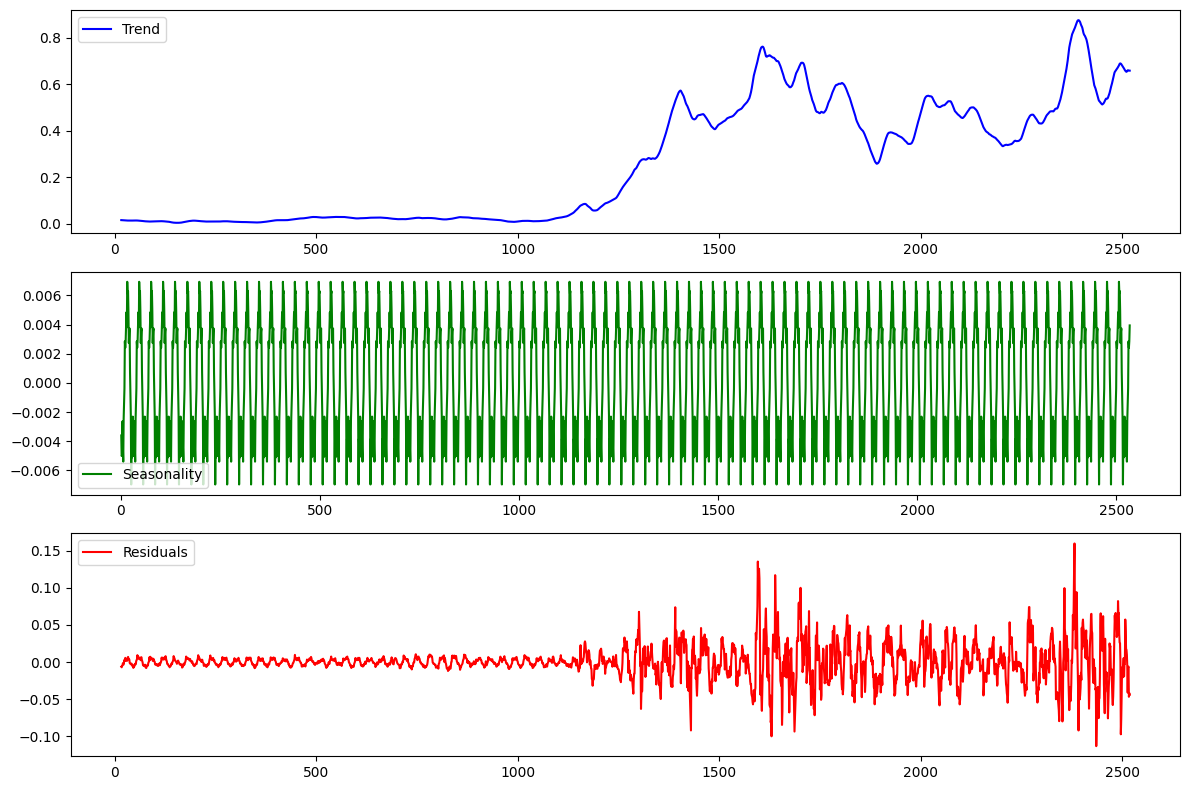

In [31]:
# Perform Trend & Seasonality Analysis
ts_analysis.decompose_time_series()

### Rolling Volatility (Standard Deviation)

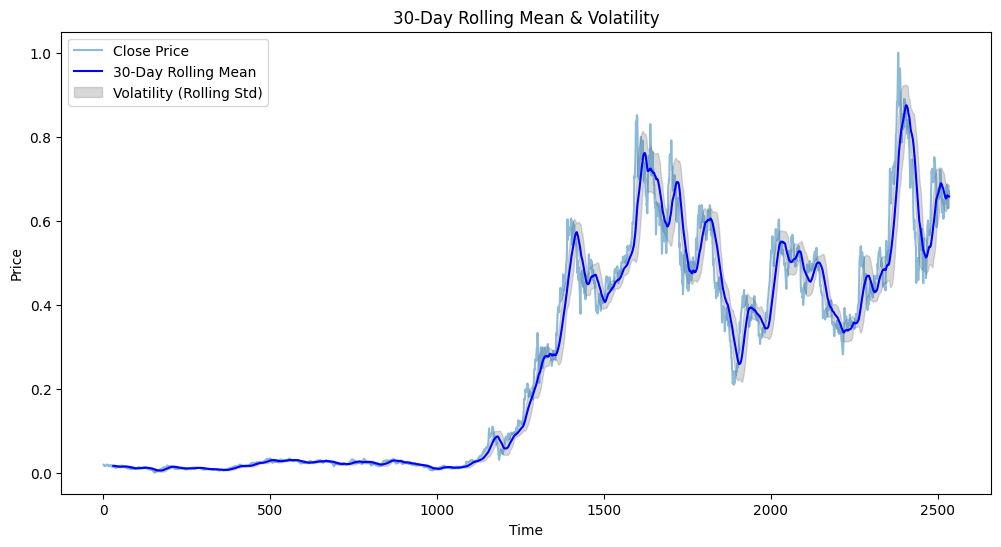

In [32]:
# Analyze Volatility & Risk
ts_analysis.rolling_volatility_analysis(window=30)

### Analyze Volatility

In [33]:
ts_analysis.risk_analysis()

VaR (95% confidence): -0.1107
Sharpe Ratio: 0.0446


# Develop Time Series Forecasting Models

## Prepare Data for Forecasting
### Train Test Split

In [34]:
data = df["Close"]
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

### Train ARIMA Model

In [35]:
# ARIMA Model
arima_forecaster = ARIMAmodel(train)
arima_forecaster.train_model()

### Forecast Using ARIMA

In [36]:
arima_predictions, _ = arima_forecaster.forecast(steps=len(test))
arima_metrics = arima_forecaster.evaluate(test)
print("ARIMA Evaluation:", arima_metrics)

ARIMA Evaluation: {'MAE': 0.18286681074690941, 'RMSE': 0.23014776928686395, 'MAPE': 25.586101323620092, 'R Squered:': -1.5609192146551094}


In [37]:
arima_forecaster.predict_future()

(2024-07-25    0.438778
 2024-07-26    0.438899
 2024-07-29    0.438789
 2024-07-30    0.438889
 2024-07-31    0.438799
 2024-08-01    0.438881
 2024-08-02    0.438806
 2024-08-05    0.438874
 2024-08-06    0.438812
 2024-08-07    0.438868
 2024-08-08    0.438817
 2024-08-09    0.438864
 2024-08-12    0.438822
 2024-08-13    0.438860
 2024-08-14    0.438825
 2024-08-15    0.438857
 2024-08-16    0.438828
 2024-08-19    0.438854
 2024-08-20    0.438830
 2024-08-21    0.438852
 2024-08-22    0.438832
 2024-08-23    0.438850
 2024-08-26    0.438834
 2024-08-27    0.438849
 2024-08-28    0.438835
 2024-08-29    0.438848
 2024-08-30    0.438836
 2024-09-02    0.438847
 2024-09-03    0.438837
 2024-09-04    0.438846
 2024-09-05    0.438838
 2024-09-06    0.438845
 2024-09-09    0.438839
 2024-09-10    0.438844
 2024-09-11    0.438839
 2024-09-12    0.438844
 2024-09-13    0.438840
 2024-09-16    0.438844
 2024-09-17    0.438840
 2024-09-18    0.438843
 2024-09-19    0.438840
 2024-09-20    0

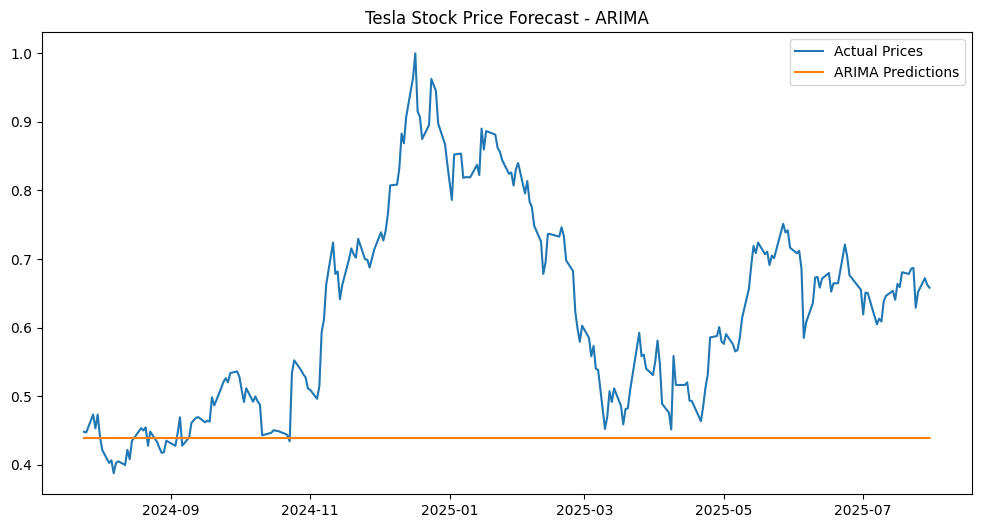

In [38]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, arima_predictions, label="ARIMA Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - ARIMA")
plt.show()

### Train SARIMA Model

In [39]:
# SARIMA Model
sarima_forecaster = SARIMA(train)
sarima_forecaster.train_model()

In [40]:
sarima_predictions, _ = sarima_forecaster.forecast(steps=len(test))
sarima_metrics = sarima_forecaster.evaluate(test)
print("SARIMA Evaluation:", sarima_metrics)

SARIMA Evaluation: {'MAE': 0.15701996637535925, 'RMSE': 0.20566300977116453, 'MAPE': 21.965908663666784, 'R-squared': -1.0450065971363567}


In [41]:
sarima_forecaster.predict_future()

(2024-07-25    0.443060
 2024-07-26    0.445239
 2024-07-27    0.447324
 2024-07-28    0.447389
 2024-07-29    0.446513
 2024-07-30    0.446798
 2024-07-31    0.447772
 2024-08-01    0.446550
 2024-08-02    0.446915
 2024-08-03    0.447935
 2024-08-04    0.446120
 2024-08-05    0.445268
 2024-08-06    0.445863
 2024-08-07    0.447045
 2024-08-08    0.448850
 2024-08-09    0.448837
 2024-08-10    0.447938
 2024-08-11    0.448217
 2024-08-12    0.449190
 2024-08-13    0.447967
 2024-08-14    0.448332
 2024-08-15    0.449352
 2024-08-16    0.447537
 2024-08-17    0.446684
 2024-08-18    0.447279
 2024-08-19    0.448461
 2024-08-20    0.450267
 2024-08-21    0.450254
 2024-08-22    0.449355
 2024-08-23    0.449634
 2024-08-24    0.450607
 2024-08-25    0.449384
 2024-08-26    0.449749
 2024-08-27    0.450769
 2024-08-28    0.448954
 2024-08-29    0.448101
 2024-08-30    0.448696
 2024-08-31    0.449878
 2024-09-01    0.451684
 2024-09-02    0.451670
 2024-09-03    0.450772
 2024-09-04    0

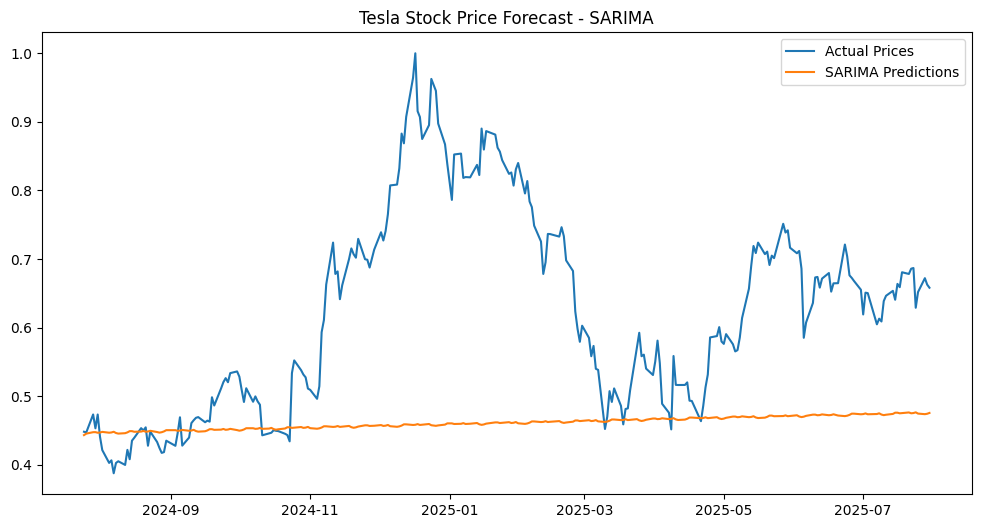

In [42]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, sarima_predictions, label="SARIMA Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - SARIMA")
plt.show()

### Train LSTM Model

In [43]:
 # LSTM Model
lstm_forecaster = LSTMForecast(train)
lstm_forecaster.train_model()

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.0077
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0027
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0023
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - loss: 0.0020
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0019
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0016
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0017
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0017
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - loss: 0.0017
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 377ms/step - loss: 0.0014
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 376ms/step - loss: 0.0014
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 377ms/step - loss: 0.0014
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 259ms/step - loss: 0.0015
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 360ms/step - loss: 0.0012
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 426ms/step 

### Forecast Using LSTM

In [45]:
lstm_forecaster.forecast()

array([0.4623945 , 0.4509923 , 0.43965623, 0.4291406 , 0.41953346,
       0.41073376, 0.40262467, 0.39511198, 0.38812023, 0.3815837 ,
       0.37544045, 0.3696333 , 0.36410904, 0.3588218 , 0.3537329 ,
       0.34881076, 0.34403145, 0.33937687, 0.33483422, 0.3303948 ,
       0.32605284, 0.32180515, 0.31764957, 0.3135851 , 0.30961093,
       0.3057265 , 0.30193105, 0.29822347, 0.2946024 , 0.29106623],
      dtype=float32)

In [47]:
lstm_forecaster.evaluate(test)

{'MAE': 0.44959357179705645,
 'RMSE': 0.49330077153698015,
 'MAPE': 69.03336924608834,
 'R Squared': -10.765379180987289}

In [48]:
lstm_forecaster.predict_future()

array([0.4623945 , 0.4509923 , 0.43965623, 0.4291406 , 0.41953346,
       0.41073376, 0.40262467, 0.39511198, 0.38812023, 0.3815837 ,
       0.37544045, 0.3696333 , 0.36410904, 0.3588218 , 0.3537329 ,
       0.34881076, 0.34403145, 0.33937687, 0.33483422, 0.3303948 ,
       0.32605284, 0.32180515, 0.31764957, 0.3135851 , 0.30961093,
       0.3057265 , 0.30193105, 0.29822347, 0.2946024 , 0.29106623,
       0.28761297, 0.28424045, 0.28094622, 0.27772793, 0.27458298,
       0.2715088 , 0.26850304, 0.26556316, 0.26268685, 0.25987187,
       0.25711626, 0.25441775, 0.25177467, 0.24918526, 0.24664778,
       0.24416061, 0.2417223 , 0.23933148, 0.23698682, 0.23468697,
       0.2324308 , 0.23021711, 0.22804478, 0.22591265, 0.22381979,
       0.2217651 , 0.21974765, 0.21776655, 0.2158208 , 0.2139095 ],
      dtype=float32)

In [50]:
train.head()

Date
2015-07-01    0.017788
2015-07-02    0.019329
2015-07-06    0.019286
2015-07-07    0.017608
2015-07-08    0.015776
Name: Close, dtype: float64

## Grid Search 

In [2]:
data = pd.read_csv('tsla.csv')
data.head()

,Date,Close
0,2015-07-01,17.943333
1,2015-07-02,18.667999
2,2015-07-06,18.648001
3,2015-07-07,17.858667
4,2015-07-08,16.997334


In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
df = data["Close"]
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

In [4]:
# Convert the 'Date' column to datetime
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])


# Initialize and train the LSTM model
forecaster = LSTM_search(data)
forecaster.train_model(batch_size=32, dropout_rate=0.2, epochs=20, lstm_units=100)

# Save the trained model (done inside train_model)

# Forecast future values using the trained model
forecast_steps = 10
forecast = forecaster.forecast(steps=forecast_steps)
print("Forecasted values:", forecast)

c:\Users\Specter\Documents\Tenx_Academy\Week-11\Time-Series-Forecasting-Portfolio-Optimization\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0074
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0024
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0022
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0019
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0018
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - loss: 0.0018
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0014
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 0.0015
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0013
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0014
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0014
Epoch 12/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0013
Epoch 13/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - loss: 0.0014
Epoch 14/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - loss: 0.0011
Epoch 15/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0

Forecasted values: [311.8142  310.63843 308.64465 306.23883 303.70203 301.17538 298.71585
 296.34064 294.05136 291.84445]


In [5]:
# Load the saved model for future predictions (optional)
loaded_model = forecaster.load_trained_model(model_path='lstm_model.h5')

# Forecast Future Market Trends

In [6]:
# forecasting with the loaded model
forecast_from_loaded_model = forecaster.forecast(steps=forecast_steps)
print("Forecast from loaded model:", forecast_from_loaded_model)

Forecast from loaded model: [311.8142  310.63843 308.64465 306.23883 303.70203 301.17538 298.71585
 296.34064 294.05136 291.84445]


In [7]:
# Forecast the next day
next_day, next_day_forecast = forecaster.forecast_next_day()
print(f"Forecast for the next day ({next_day}): {next_day_forecast}")

Forecast for the next day (2025-08-15): 311.814208984375


In [8]:
# Forecast the next 30 days
next_30_days = forecaster.forecast_next_30_days()
print("Forecast for the next 30 days:")
for date, forecast in next_30_days:
    print(f"{date}: {forecast}")

Forecast for the next 30 days:
2025-08-15: 311.814208984375
2025-08-16: 310.638427734375
2025-08-17: 308.6446533203125
2025-08-18: 306.23883056640625
2025-08-19: 303.7020263671875
2025-08-20: 301.1753845214844
2025-08-21: 298.7158508300781
2025-08-22: 296.34063720703125
2025-08-23: 294.0513610839844
2025-08-24: 291.8444519042969
2025-08-25: 289.7148742675781
2025-08-26: 287.6572265625
2025-08-27: 285.66583251953125
2025-08-28: 283.7353515625
2025-08-29: 281.8603515625
2025-08-30: 280.03631591796875
2025-08-31: 278.259033203125
2025-09-01: 276.52471923828125
2025-09-02: 274.8304443359375
2025-09-03: 273.173828125
2025-09-04: 271.552734375
2025-09-05: 269.9653625488281
2025-09-06: 268.4105529785156
2025-09-07: 266.886962890625
2025-09-08: 265.3937072753906
2025-09-09: 263.92987060546875
2025-09-10: 262.4946594238281
2025-09-11: 261.08740234375
2025-09-12: 259.7072448730469
2025-09-13: 258.3536376953125


In [9]:
# Forecast for a selected date range (e.g., 2020-01-10 to 2020-01-15)
selected_date_range = forecaster.forecast_selected_date(start_date='2020-01-10', end_date='2020-01-15')
print("Forecast for selected date range:")
for date, forecast in selected_date_range:
    print(f"{date}: {forecast}")

Forecast for selected date range:
2020-01-10: 311.814208984375
2020-01-11: 310.638427734375
2020-01-12: 308.6446533203125
2020-01-13: 306.23883056640625
2020-01-14: 303.7020263671875
2020-01-15: 301.1753845214844


In [10]:
# Evaluate and forecast the next 30 days after training and evaluation
forecast_30_days = forecaster.evaluate_and_forecast(test_size=0.2, batch_size=32, dropout_rate=0.2, epochs=20, lstm_units=100)

Epoch 1/20


c:\Users\Specter\Documents\Tenx_Academy\Week-11\Time-Series-Forecasting-Portfolio-Optimization\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0070
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0025
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0021
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0021
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0017
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0017
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0019
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0016
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0015
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0015
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - loss: 0.0015
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0014
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0013
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0014
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0015
Epoch 16/

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Mean Absolute Error (MAE): 5.261300754014069
Mean Squared Error (MSE): 81.46375670727838
Root Mean Squared Error (RMSE): 9.025727489087979
R-squared (R²): 0.993373285930577


In [11]:
forecast_30_days

[('2025-08-15', 276.1172),
 ('2025-08-16', 271.4054),
 ('2025-08-17', 267.7205),
 ('2025-08-18', 264.96603),
 ('2025-08-19', 262.83777),
 ('2025-08-20', 261.09323),
 ('2025-08-21', 259.59363),
 ('2025-08-22', 258.27316),
 ('2025-08-23', 257.10205),
 ('2025-08-24', 256.0634),
 ('2025-08-25', 255.14212),
 ('2025-08-26', 254.32149),
 ('2025-08-27', 253.58382),
 ('2025-08-28', 252.91165),
 ('2025-08-29', 252.28891),
 ('2025-08-30', 251.70123),
 ('2025-08-31', 251.13683),
 ('2025-09-01', 250.58647),
 ('2025-09-02', 250.04295),
 ('2025-09-03', 249.50127),
 ('2025-09-04', 248.95824),
 ('2025-09-05', 248.41216),
 ('2025-09-06', 247.86246),
 ('2025-09-07', 247.30951),
 ('2025-09-08', 246.75447),
 ('2025-09-09', 246.19867),
 ('2025-09-10', 245.64394),
 ('2025-09-11', 245.09198),
 ('2025-09-12', 244.54463),
 ('2025-09-13', 244.00343)]

In [14]:
#lstm_predictions = LSTM_search.forecast(steps=len(test))
#lstm_metrics = LSTM_search.evaluate(test)
#print("LSTM Evaluation:", lstm_metrics)

In [15]:
df_sample = data.sample(frac=0.1, random_state=42)  # 10% random rows

### Forecast Analysis

In [16]:
predictions = forecaster.predict_test_data(df_sample)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


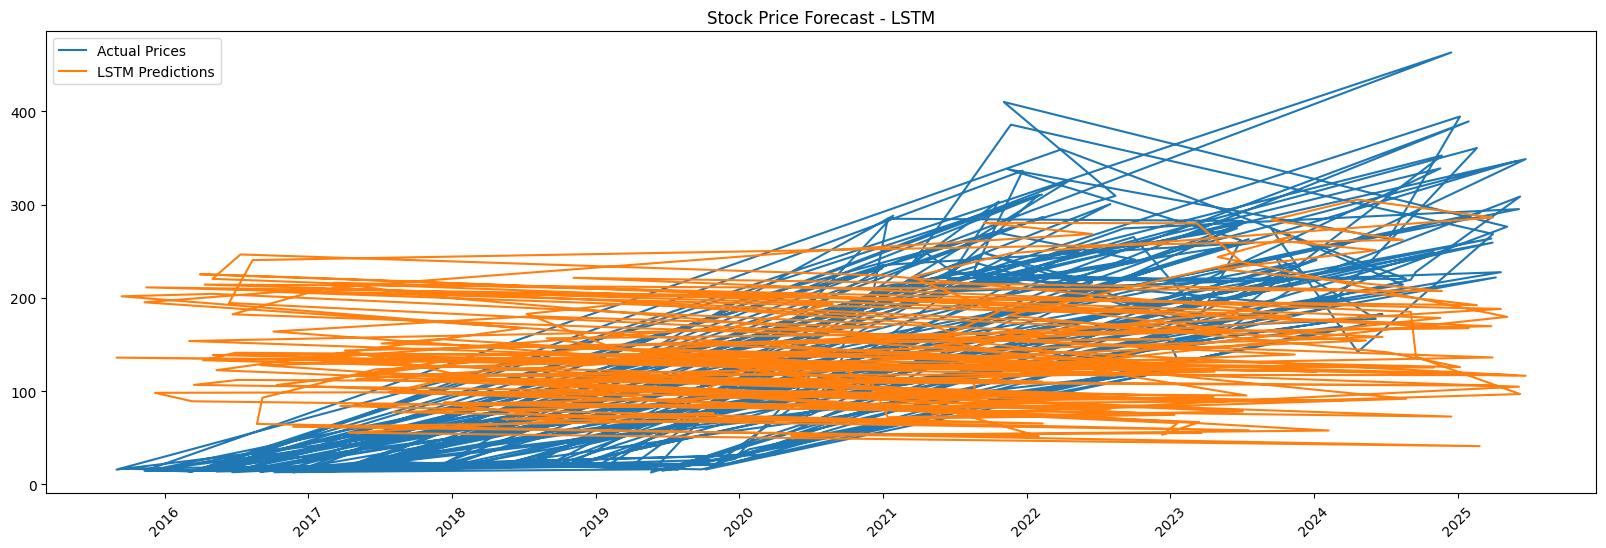

In [17]:
# Plot results
time_steps = 60
aligned_test_index = df_sample.Date[time_steps:]

plt.figure(figsize=(20, 6))
plt.plot(aligned_test_index, df_sample['Close'][time_steps:], label="Actual Prices")
plt.plot(aligned_test_index, predictions, label="LSTM Predictions")

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.legend()
plt.title("Stock Price Forecast - LSTM")
plt.show()

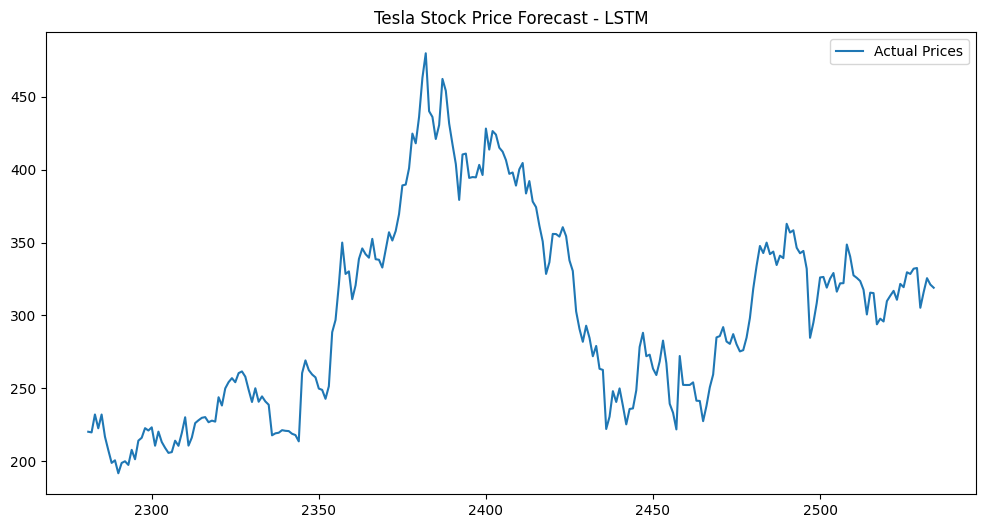

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, lstm_predictions, label="LSTM Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - LSTM")
plt.show()

In [ ]:
LSTM_search.predict_future()

# Optimize Portfolio Based on Forecast
### Portfolio Simulation